<a href="https://colab.research.google.com/github/Paimonz/computer-vision/blob/main/ImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
print('TensorFlow version:', tf.__version__)
print('TensorFlow Hub version:', hub.__version__)

TensorFlow version: 2.12.0
TensorFlow Hub version: 0.14.0


In [2]:
model_name = 'efficientnetv2-b2-21k'

In [3]:
models_path = {
    "efficientnetv2-b2-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b2/feature_vector/2",
}

In [4]:
models_pixels = {
    "efficientnetv2-b2-21k": 260
}

In [5]:
model_path = models_path.get(model_name)
model_path


'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b2/feature_vector/2'

In [6]:
pixels = models_pixels.get(model_name)
pixels

260

In [7]:
image_size = (pixels, pixels)
image_size

(260, 260)

In [8]:
print('Model: ', model_name)
print('Path: ', model_path)
print('Imagem size: ', image_size)

Model:  efficientnetv2-b2-21k
Path:  https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b2/feature_vector/2
Imagem size:  (260, 260)


In [9]:
from keras.preprocessing.image import ImageDataGenerator

In [10]:
flow_from_directory = "/content/drive/MyDrive/Colab Notebooks/dataset"
data_directory = flow_from_directory
print(data_directory)

/content/drive/MyDrive/Colab Notebooks/dataset


In [11]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_directory,
                                                                    validation_split= .20,
                                                                    subset = 'training',
                                                                    label_mode='categorical',
                                                                    seed = 123,
                                                                    image_size=image_size,
                                                                    batch_size=1)

Found 1050 files belonging to 2 classes.
Using 840 files for training.


In [12]:
train_dataset.class_names

['cataract', 'normal']

In [13]:
classes = train_dataset.class_names
classes

['cataract', 'normal']

In [14]:
training_size = train_dataset.cardinality().numpy()
training_size

840

In [15]:
BATCH_SIZE = 16


In [16]:
train_dataset = train_dataset.unbatch().batch(BATCH_SIZE)
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 260, 260, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>

In [17]:
840/16


52.5

In [18]:
train_dataset = train_dataset.repeat()

In [19]:
from multiprocessing.process import parent_process
normalization_layer = tf.keras.layers.Rescaling(1. /255)
pre_processing = tf.keras.Sequential([normalization_layer])
pre_processing.add(tf.keras.layers.RandomRotation(40))
pre_processing.add(tf.keras.layers.RandomTranslation(0, 0.2))
pre_processing.add(tf.keras.layers.RandomTranslation(0.2, 0))
pre_processing.add(tf.keras.layers.RandomZoom(0.2, 0.2))
pre_processing.add(tf.keras.layers.RandomFlip(mode = 'horizontal'))

In [20]:
train_dataset = train_dataset.map(lambda images, labels: (pre_processing(images), labels))
train_dataset

<_MapDataset element_spec=(TensorSpec(shape=(None, 260, 260, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>

In [21]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_directory,
                                                                   validation_split= .20,
                                                                   subset ='validation',
                                                                   label_mode ='categorical',
                                                                   seed = 123,
                                                                   image_size = image_size,
                                                                   batch_size = 1)

Found 1050 files belonging to 2 classes.
Using 210 files for validation.


In [22]:
test_size = test_dataset.cardinality().numpy()
test_size

210

In [23]:
test_dataset = test_dataset.unbatch().batch(BATCH_SIZE)
test_dataset = test_dataset.map(lambda images, labels: (pre_processing(images), labels))

In [26]:
model = tf.keras.Sequential([
                              tf.keras.layers.InputLayer(input_shape= image_size + (3,)),
                              hub.KerasLayer(model_path, trainable = False),
                              tf.keras.layers.Dropout(rate = 0.2),
                              tf.keras.layers.Dense(len(classes))
])

In [24]:
(None, ) + image_size + (3, )

(None, 260, 260, 3)

In [27]:
model.build((None, )+ image_size + (3,))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1408)              8769374   
                                                                 
 dropout (Dropout)           (None, 1408)              0         
                                                                 
 dense (Dense)               (None, 2)                 2818      
                                                                 
Total params: 8,772,192
Trainable params: 2,818
Non-trainable params: 8,769,374
_________________________________________________________________


In [28]:
model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics = 'accuracy')

In [29]:
steps_per_epoch = training_size // BATCH_SIZE
validation_steps = test_size // BATCH_SIZE
print(steps_per_epoch, validation_steps)

52 13


In [30]:
hist = model.fit(train_dataset, epochs= 10, steps_per_epoch = steps_per_epoch,
                 validation_data = test_dataset, validation_steps = validation_steps).history

Epoch 1/10
52/52 [==============================] - 336s 6s/step - loss: 0.5574 - accuracy: 0.8125 - val_loss: 0.1343 - val_accuracy: 0.9519
Epoch 2/10
52/52 [==============================] - 152s 3s/step - loss: 0.1954 - accuracy: 0.9150 - val_loss: 0.0986 - val_accuracy: 0.9519
Epoch 3/10
52/52 [==============================] - 153s 3s/step - loss: 0.1792 - accuracy: 0.9308 - val_loss: 0.0955 - val_accuracy: 0.9615
Epoch 4/10
52/52 [==============================] - 140s 3s/step - loss: 0.1531 - accuracy: 0.9466 - val_loss: 0.0991 - val_accuracy: 0.9519
Epoch 5/10
52/52 [==============================] - 152s 3s/step - loss: 0.1299 - accuracy: 0.9490 - val_loss: 0.0973 - val_accuracy: 0.9663
Epoch 6/10
52/52 [==============================] - 153s 3s/step - loss: 0.1239 - accuracy: 0.9478 - val_loss: 0.0872 - val_accuracy: 0.9663
Epoch 7/10
52/52 [==============================] - 141s 3s/step - loss: 0.1384 - accuracy: 0.9490 - val_loss: 0.0937 - val_accuracy: 0.9663
Epoch 8/10
52

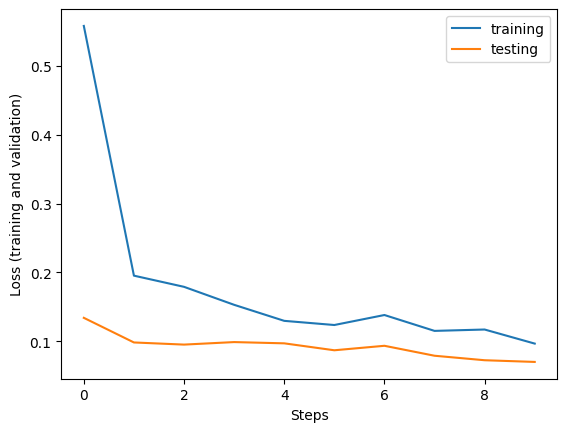

In [31]:
plt.figure()
plt.ylabel('Loss (training and validation)')
plt.xlabel('Steps')
plt.plot(hist['loss'], label = 'training')
plt.plot(hist['val_loss'], label = 'testing')
plt.legend();

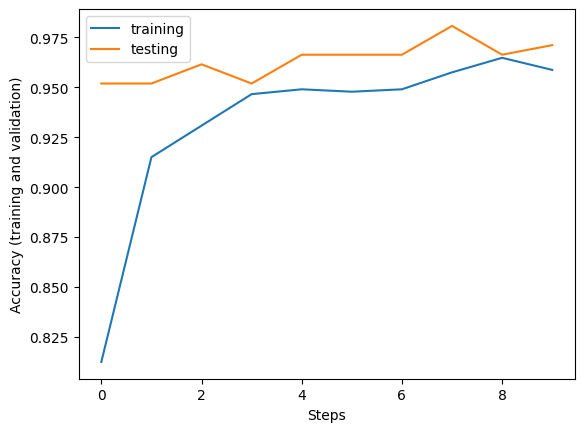

In [32]:
plt.figure()
plt.ylabel('Accuracy (training and validation)')
plt.xlabel('Steps')
plt.plot(hist['accuracy'], label = 'training')
plt.plot(hist['val_accuracy'], label = 'testing')
plt.legend();

In [36]:
x, y = next(iter(test_dataset))


In [41]:
x

<tf.Tensor: shape=(16, 260, 260, 3), dtype=float32, numpy=
array([[[[1.88633765e-03, 1.77837280e-03, 4.88267950e-04],
         [1.07919788e-02, 7.45651126e-03, 3.66012170e-03],
         [5.65968677e-02, 3.83785516e-02, 2.81220470e-02],
         ...,
         [5.38248897e-01, 3.67423296e-01, 2.72856355e-01],
         [5.33671141e-01, 3.65247011e-01, 2.71604180e-01],
         [5.44226050e-01, 3.71786237e-01, 2.78873533e-01]],

        [[2.75459752e-04, 1.90174836e-03, 1.39707327e-03],
         [4.06368403e-03, 4.77927877e-03, 1.63582654e-03],
         [3.02532762e-02, 2.23806500e-02, 1.46881994e-02],
         ...,
         [6.02643192e-01, 3.96802425e-01, 2.91699290e-01],
         [6.03517890e-01, 4.02813137e-01, 2.96443284e-01],
         [6.02387547e-01, 4.02119577e-01, 2.96619087e-01]],

        [[4.27036775e-06, 1.94178498e-03, 2.52354145e-03],
         [1.72292965e-03, 3.78716341e-03, 1.06081215e-03],
         [1.84690990e-02, 1.52835231e-02, 8.38361308e-03],
         ...,
         [

In [38]:
x.shape

TensorShape([16, 260, 260, 3])

In [42]:
y

<tf.Tensor: shape=(16, 2), dtype=float32, numpy=
array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)>

In [40]:
y.shape

TensorShape([16, 2])

In [46]:
image = x[0, :, :, :]
image

<tf.Tensor: shape=(260, 260, 3), dtype=float32, numpy=
array([[[1.8863376e-03, 1.7783728e-03, 4.8826795e-04],
        [1.0791979e-02, 7.4565113e-03, 3.6601217e-03],
        [5.6596868e-02, 3.8378552e-02, 2.8122047e-02],
        ...,
        [5.3824890e-01, 3.6742330e-01, 2.7285635e-01],
        [5.3367114e-01, 3.6524701e-01, 2.7160418e-01],
        [5.4422605e-01, 3.7178624e-01, 2.7887353e-01]],

       [[2.7545975e-04, 1.9017484e-03, 1.3970733e-03],
        [4.0636840e-03, 4.7792788e-03, 1.6358265e-03],
        [3.0253276e-02, 2.2380650e-02, 1.4688199e-02],
        ...,
        [6.0264319e-01, 3.9680243e-01, 2.9169929e-01],
        [6.0351789e-01, 4.0281314e-01, 2.9644328e-01],
        [6.0238755e-01, 4.0211958e-01, 2.9661909e-01]],

       [[4.2703678e-06, 1.9417850e-03, 2.5235415e-03],
        [1.7229296e-03, 3.7871634e-03, 1.0608122e-03],
        [1.8469099e-02, 1.5283523e-02, 8.3836131e-03],
        ...,
        [6.0365647e-01, 3.8318455e-01, 2.8421900e-01],
        [6.0751849e-01

In [47]:
y_true = np.argmax(y[0])
y_true

1

In [48]:
classes[1]

'normal'

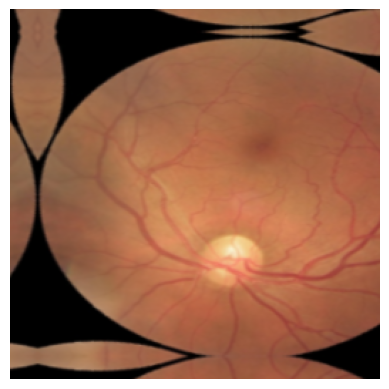

In [51]:
plt.imshow(image)
plt.axis('off');

In [52]:
image.shape

TensorShape([260, 260, 3])

In [53]:
image = np.expand_dims(image, axis = 0)
image.shape

(1, 260, 260, 3)

In [54]:
prediction = model.predict(image)
prediction

1/1 [==============================] - 3s 3s/step


array([[-3.6178818,  3.1566858]], dtype=float32)

In [55]:
prediction = np.argmax(prediction)
prediction

1